<a href="https://colab.research.google.com/github/xyt556/Geo_Programme/blob/main/03_creating_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 概述

与 Pandas 类似，GeoPandas 也有一个 `plot()` 方法，可以使用 Matplotlib 绘制地理空间数据。

我们将使用人口普查数据创建一个人口密度的分级统计图。我们将从人口普查区的 shapefile 开始，并将其与表格数据连接，以获得包含人口普查区几何形状和相应人口的 GeoDataframe。

## 设置和数据下载

以下代码块将安装所需的包并将数据集下载到你的 Colab 环境中。


In [2]:
%%capture
if 'google.colab' in str(get_ipython()):
  !apt install libspatialindex-dev
  !pip install fiona shapely pyproj rtree mapclassify
  !pip install geopandas

这段代码的作用是为 Google Colab 环境安装必要的库和依赖，以便处理地理数据。具体如下：

1. **`if 'google.colab' in str(get_ipython()):`**  
   这一行检查代码是否在 Google Colab 环境中运行。如果是，它将执行后面的安装命令。

2. **`!apt install libspatialindex-dev`**  
   使用 `apt` 安装 `libspatialindex-dev`，这是处理空间索引的必备库，许多地理处理工具依赖于它，特别是 `rtree` 库。

3. **`!pip install fiona shapely pyproj rtree mapclassify`**  
   这一行使用 `pip` 安装了一些处理地理数据的 Python 库：
   - **`fiona`**：用于读取和写入地理数据文件，如 Shapefile。
   - **`shapely`**：用于处理几何对象。
   - **`pyproj`**：用于处理坐标投影和转换。
   - **`rtree`**：用于进行空间索引和查询。
   - **`mapclassify`**：用于地图分类（如用于 Choropleth 图）。

4. **`!pip install geopandas`**  
   这一行安装了 `geopandas`，它是用于处理地理数据的扩展库，结合了 Pandas 和地理处理功能。

总的来说，这段代码的目的是确保 Colab 环境具备处理地理空间数据（如 Shapefile）的必要工具和库。

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd


In [4]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [5]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

我们将下载人口普查区的 shapefile 文件和一个包含每个区各种人口统计数据的 CSV 文件。

(1) 2022 Cartographic Boundary File (SHP), Current Census Tract for United .... https://catalog.data.gov/dataset/2022-cartographic-boundary-file-shp-current-census-tract-for-united-states-1-500000.
(2) Census 2020 Data Hub. https://2020-wecount.hub.arcgis.com/.
(3) Downloading TIGER/Line® Shapeﬁles - Census.gov. https://www2.census.gov/geo/pdfs/education/brochures/DownloadingTIGERLineShapefiles.pdf.
(4) Cartographic Boundary Files - Shapefile - Census.gov. https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html.

In [6]:
shapefile_name = 'tl_2019_06_tract'
shapefile_exts = ['.shp', '.shx', '.dbf', '.prj']
data_url = 'https://github.com/xyt556/python-dataviz-web/raw/main/data/census/'

for ext in shapefile_exts:
  url = data_url + shapefile_name + ext
  download(url)

csv_name = 'ACSST5Y2019.S0101_data.csv'
download(data_url + csv_name)


Downloaded data/tl_2019_06_tract.shp
Downloaded data/tl_2019_06_tract.shx
Downloaded data/tl_2019_06_tract.dbf
Downloaded data/tl_2019_06_tract.prj
Downloaded data/ACSST5Y2019.S0101_data.csv


### ## 数据预处理

让我们读取人口普查区的 shapefile 文件和包含人口统计数据的 CSV 文件。

In [7]:
shapefile_path = os.path.join(data_folder, shapefile_name + '.shp')
tracts = gpd.read_file(shapefile_path)
tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1..."
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1..."
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1..."
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1..."
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,06,001,443001,06001443001,4430.01,Census Tract 4430.01,G5020,S,768730,0,+37.5184218,-121.9515237,"POLYGON ((-121.95760 37.52392, -121.95745 37.5..."
8053,06,001,443002,06001443002,4430.02,Census Tract 4430.02,G5020,S,1580323,0,+37.5168344,-121.9605916,"POLYGON ((-121.96900 37.52248, -121.96885 37.5..."
8054,06,001,443102,06001443102,4431.02,Census Tract 4431.02,G5020,S,2367415,0,+37.5072245,-121.9271486,"POLYGON ((-121.93952 37.51476, -121.93926 37.5..."
8055,06,001,443301,06001443301,4433.01,Census Tract 4433.01,G5020,S,1577680,0,+37.4707325,-121.9129556,"POLYGON ((-121.92094 37.47505, -121.92092 37.4..."


现在我们读取包含每个区各种人口统计数据的文件。我们将此文件读取为 Pandas DataFrame。由于 CSV 文件在标题前包含一行额外的内容，因此我们指定 `skiprows=[1]` 来跳过读取它。

In [8]:
csv_path = os.path.join(data_folder, csv_name)
table = pd.read_csv(csv_path, skiprows=[1])
table

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C06_034E,S0101_C06_034M,S0101_C06_035E,S0101_C06_035M,S0101_C06_036E,S0101_C06_036M,S0101_C06_037E,S0101_C06_037M,S0101_C06_038E,S0101_C06_038M
0,1400000US06001400100,"Census Tract 4001, Alameda County, California",3120,208,188,94,56,49,168,73,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,1400000US06001400200,"Census Tract 4002, Alameda County, California",2007,120,142,50,68,30,122,46,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,1400000US06001400300,"Census Tract 4003, Alameda County, California",5051,309,204,120,373,114,104,80,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,1400000US06001400400,"Census Tract 4004, Alameda County, California",4007,344,180,70,196,96,271,103,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,1400000US06001400500,"Census Tract 4005, Alameda County, California",4124,357,254,82,122,55,168,87,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,1400000US06115040800,"Census Tract 408, Yuba County, California",4652,247,173,101,292,83,275,90,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8053,1400000US06115040901,"Census Tract 409.01, Yuba County, California",2720,298,153,81,219,98,84,40,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8054,1400000US06115040902,"Census Tract 409.02, Yuba County, California",1653,334,140,71,99,48,124,100,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8055,1400000US06115041000,"Census Tract 410, Yuba County, California",7298,789,580,208,534,176,476,276,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


为了将这个 DataFrame 与 GeoDataFrame 连接起来，我们需要一个包含唯一标识符的列。我们使用 `GEOID` 列，并处理 ID 以确保它们在两个数据集中完全匹配。

In [9]:
# 选择表格中的特定列：'GEO_ID', 'NAME', 'S0101_C01_001E'，并创建一个新的DataFrame
filtered = table[['GEO_ID','NAME', 'S0101_C01_001E']]

# 重命名列名：将'S0101_C01_001E'改为'Population'（表示人口），'GEO_ID'改为'GEOID'
filtered = filtered.rename(columns = {'S0101_C01_001E': 'Population', 'GEO_ID': 'GEOID'})

# 修改'GEOID'列，保留最后11个字符
filtered['GEOID'] = filtered.GEOID.str[-11:]
filtered

,GEOID,NAME,Population
0,06001400100,"Census Tract 4001, Alameda County, California",3120
1,06001400200,"Census Tract 4002, Alameda County, California",2007
2,06001400300,"Census Tract 4003, Alameda County, California",5051
3,06001400400,"Census Tract 4004, Alameda County, California",4007
4,06001400500,"Census Tract 4005, Alameda County, California",4124
...,...,...,...
8052,06115040800,"Census Tract 408, Yuba County, California",4652
8053,06115040901,"Census Tract 409.01, Yuba County, California",2720
8054,06115040902,"Census Tract 409.02, Yuba County, California",1653
8055,06115041000,"Census Tract 410, Yuba County, California",7298


最后，我们使用 `merge` 方法进行表连接。

In [10]:
gdf = tracts.merge(filtered, on='GEOID')
gdf

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,Population
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1...","Census Tract 1393.01, Los Angeles County, Cali...",4445
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1...","Census Tract 1393.02, Los Angeles County, Cali...",5000
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1...","Census Tract 1395.02, Los Angeles County, Cali...",2917
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1...","Census Tract 1396, Los Angeles County, California",5060
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1...","Census Tract 1397.01, Los Angeles County, Cali...",5320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,06,001,443001,06001443001,4430.01,Census Tract 4430.01,G5020,S,768730,0,+37.5184218,-121.9515237,"POLYGON ((-121.95760 37.52392, -121.95745 37.5...","Census Tract 4430.01, Alameda County, California",2891
8053,06,001,443002,06001443002,4430.02,Census Tract 4430.02,G5020,S,1580323,0,+37.5168344,-121.9605916,"POLYGON ((-121.96900 37.52248, -121.96885 37.5...","Census Tract 4430.02, Alameda County, California",6930
8054,06,001,443102,06001443102,4431.02,Census Tract 4431.02,G5020,S,2367415,0,+37.5072245,-121.9271486,"POLYGON ((-121.93952 37.51476, -121.93926 37.5...","Census Tract 4431.02, Alameda County, California",5065
8055,06,001,443301,06001443301,4433.01,Census Tract 4433.01,G5020,S,1577680,0,+37.4707325,-121.9129556,"POLYGON ((-121.92094 37.47505, -121.92092 37.4...","Census Tract 4433.01, Alameda County, California",4355


为了创建分级统计图，我们必须对人口统计数据进行标准化。美国人口普查局[建议](https://www.census.gov/quickfacts/fact/note/US/LND110210)通过将总人口除以土地面积来计算人口密度。原始 shapefile 文件包含一个名为 `ALAND` 的列，表示以平方公里为单位的土地面积。使用它，我们计算出一个新的列 `density`，表示每平方公里的人口数。

In [11]:
# 计算人口密度，并创建一个新列 'density'
# 人口密度 = 人口数量（'Population'）除以陆地面积（'ALAND'）
# 由于 'ALAND' 的单位通常是平方米，为了将结果转换为每平方千米，乘以 1e6
gdf['density'] = 1e6 * gdf['Population'] / gdf['ALAND']

# 显示更新后的 GeoDataFrame
gdf


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,Population,density
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1...","Census Tract 1393.01, Los Angeles County, Cali...",4445,1551.127717
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1...","Census Tract 1393.02, Los Angeles County, Cali...",5000,14780.261847
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1...","Census Tract 1395.02, Los Angeles County, Cali...",2917,2784.597937
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1...","Census Tract 1396, Los Angeles County, California",5060,2042.396272
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1...","Census Tract 1397.01, Los Angeles County, Cali...",5320,1566.366231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,06,001,443001,06001443001,4430.01,Census Tract 4430.01,G5020,S,768730,0,+37.5184218,-121.9515237,"POLYGON ((-121.95760 37.52392, -121.95745 37.5...","Census Tract 4430.01, Alameda County, California",2891,3760.748247
8053,06,001,443002,06001443002,4430.02,Census Tract 4430.02,G5020,S,1580323,0,+37.5168344,-121.9605916,"POLYGON ((-121.96900 37.52248, -121.96885 37.5...","Census Tract 4430.02, Alameda County, California",6930,4385.179485
8054,06,001,443102,06001443102,4431.02,Census Tract 4431.02,G5020,S,2367415,0,+37.5072245,-121.9271486,"POLYGON ((-121.93952 37.51476, -121.93926 37.5...","Census Tract 4431.02, Alameda County, California",5065,2139.464352
8055,06,001,443301,06001443301,4433.01,Census Tract 4433.01,G5020,S,1577680,0,+37.4707325,-121.9129556,"POLYGON ((-121.92094 37.47505, -121.92092 37.4...","Census Tract 4433.01, Alameda County, California",4355,2760.382334


## 创建分级统计图

`plot()` 方法将把数据渲染到图表中。

参考：[geopandas.GeoDataFrame.plot](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)

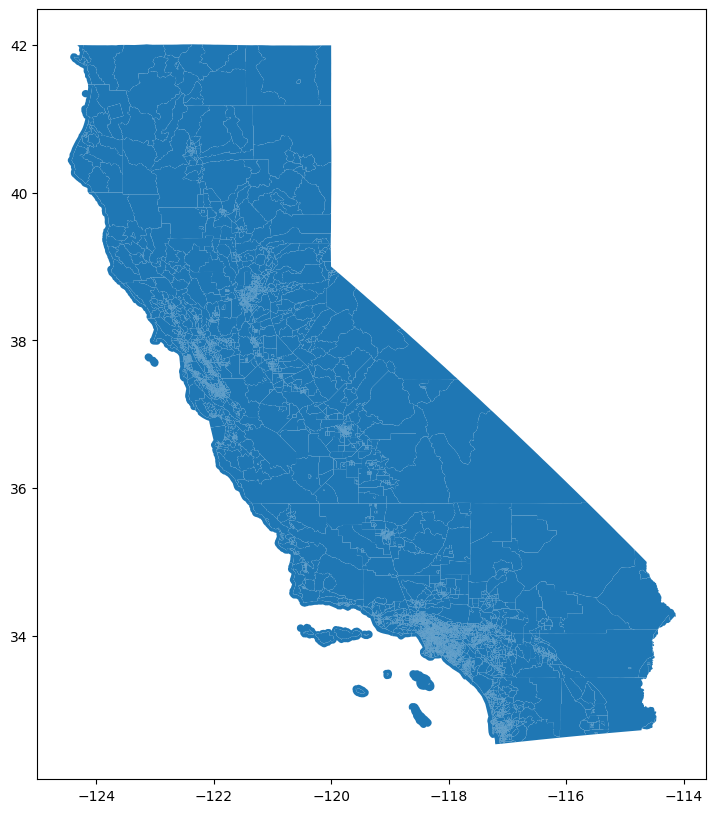

In [12]:
# 创建一个包含 1 行 1 列子图的图形对象和轴对象
fig, ax = plt.subplots(1, 1)

# 设置图形的大小为 10x10 英寸
fig.set_size_inches(10, 10)

# 在指定的轴（ax）上绘制 GeoDataFrame (gdf)
gdf.plot(ax=ax)

# 显示绘制的图形
plt.show()


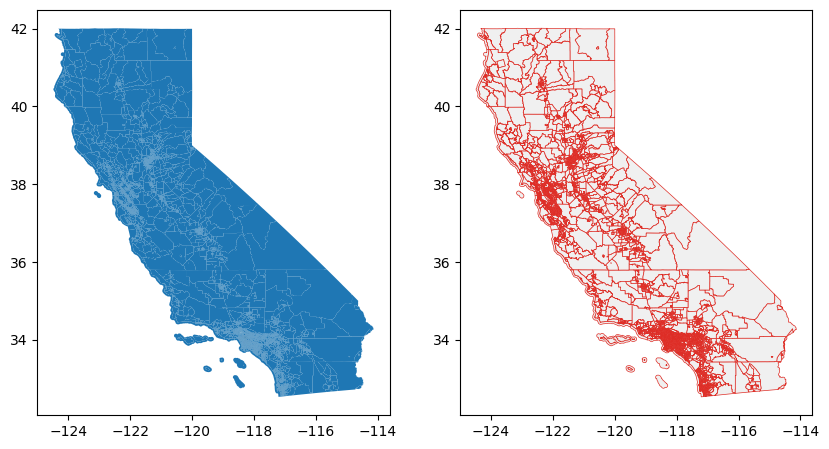

In [15]:
# 创建一个包含 1 行 2 列子图的图形对象和两个轴对象
fig, (ax1, ax2) = plt.subplots(1, 2)

# 设置图形的大小为 10x10 英寸
fig.set_size_inches(10, 10)

# 在第一个子图（ax1）上绘制 GeoDataFrame (gdf)
gdf.plot(ax=ax1)

# 在第二个子图（ax2）上绘制 GeoDataFrame (gdf)
gdf.plot(ax=ax2, facecolor='#f0f0f0', edgecolor='#de2d26', linewidth=0.5)

# 显示绘制的图形
plt.show()


你可以提供额外的样式选项来改变地图的外观。`facecolor` 和 `edgecolor` 参数分别用于确定填充颜色和轮廓颜色。可以使用 `linewidth` 参数调整线条宽度。

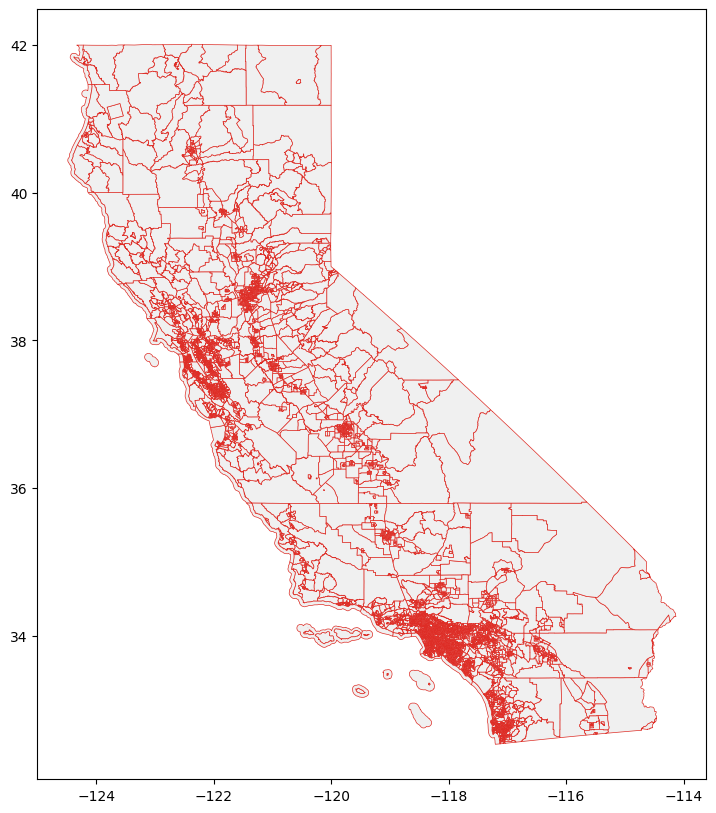

In [16]:
# 创建一个包含 1 行 1 列子图的图形对象和轴对象
fig, ax = plt.subplots(1, 1)

# 设置图形的大小为 10x10 英寸
fig.set_size_inches(10, 10)

# 在指定的轴（ax）上绘制 GeoDataFrame (gdf)
# 设置面颜色为淡灰色（'#f0f0f0'），边框颜色为红色（'#de2d26'），边框线宽为 0.5
gdf.plot(ax=ax, facecolor='#f0f0f0', edgecolor='#de2d26', linewidth=0.5)

# 显示绘制的图形
plt.show()


我们在 `density` 列中有每个区的人口密度。我们可以根据此列中的值为每个多边形分配颜色，从而生成一个分级统计图。此外，我们需要使用 `cmap` 指定颜色渐变，并使用 `scheme` 指定分类方案。分类方案将决定如何将连续数据分类为离散的区间。

> 提示：你可以在任何颜色渐变名称后添加 `_r` 来获得该渐变的**反转**版本。

参考：
- [Matplotlib 颜色映射](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
- [Mapclassify 分类方案](https://pysal.org/mapclassify/generated/mapclassify.classify.html#mapclassify.classify)

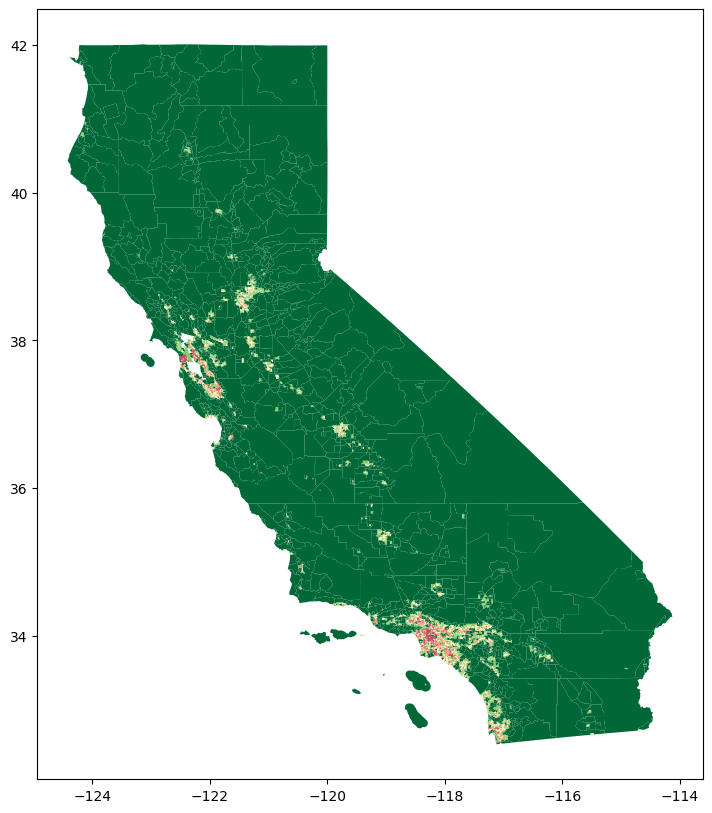

In [19]:
# 创建一个包含 1 行 1 列子图的图形对象和轴对象
fig, ax = plt.subplots(1, 1)

# 设置图形的大小为 10x10 英寸
fig.set_size_inches(10, 10)

# 在指定的轴（ax）上绘制 GeoDataFrame (gdf)
# 使用 'density' 列作为着色依据
# 设置颜色映射为 'RdYlGn_r'（反转的红-黄-绿色图）
# 'scheme' 参数设置为 'quantiles'，表示使用分位数分组方式来显示不同的密度值
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='quantiles')

# 显示绘制的图形
plt.show()


在 `geopandas` 中，`cmap` 参数用于指定数据可视化时的颜色映射方案（colormap）。`cmap` 的取值来自于 `matplotlib` 中的颜色映射表。这里是常用的几类 `cmap` 取值：

### 1. **连续型（Sequential）色彩映射**
   适合用于具有从低到高连续变化的数据。

   - **Blues**：从浅蓝到深蓝。
   - **Greens**：从浅绿到深绿。
   - **Oranges**：从浅橙到深橙。
   - **Purples**：从浅紫到深紫。
   - **Reds**：从浅红到深红。
   
   ```python
   gdf.plot(column='density', cmap='Blues')
   ```

### 2. **离散型（Diverging）色彩映射**
   用于强调数据的高低对比，例如正负值的分布。

   - **RdYlGn**：红-黄-绿，红色表示低值，绿色表示高值。
   - **RdBu**：红-蓝对比，适合正负数据（红表示正，蓝表示负）。
   - **PiYG**：粉-绿对比。
   - **PuOr**：紫-橙对比。
   - **Spectral**：多色的分段色彩映射。
   
   ```python
   gdf.plot(column='density', cmap='RdYlGn')
   ```

   **加 `_r`** 可以反转颜色顺序：
   
   ```python
   gdf.plot(column='density', cmap='RdYlGn_r')
   ```

### 3. **定性（Qualitative）色彩映射**
   适合用于分类数据，给每个类别分配不同的颜色。

   - **Set1**：一组强烈的颜色。
   - **Set2**：一组柔和的颜色。
   - **Paired**：配对颜色，适合成对类别的可视化。
   - **Dark2**：深色调。
   - **Pastel1**：一组浅色调。
   
   ```python
   gdf.plot(column='category', cmap='Set1')
   ```

### 4. **循环型（Cyclic）色彩映射**
   适合用来表示角度、方向等循环数据。

   - **twilight**：渐变的双色循环。
   - **hsv**：从红色到紫色的循环色彩映射。
   
   ```python
   gdf.plot(column='angle', cmap='twilight')
   ```

### 5. **感知均匀（Perceptually Uniform）色彩映射**
   这类色图在色彩上更加均匀，适合科学和工程可视化。

   - **viridis**：默认的均匀色彩映射。
   - **plasma**：鲜亮的均匀色彩映射。
   - **inferno**：从暗到亮的均匀色彩映射。
   - **magma**：从黑色到橙色的均匀色彩映射。
   - **cividis**：色盲友好的渐变色图。
   
   ```python
   gdf.plot(column='density', cmap='viridis')
   ```

你可以使用 `matplotlib` 提供的完整 `cmap` 列表来挑选合适的颜色映射方案，根据你的数据特征和可视化需求灵活选择。

在 `geopandas` 中的 `plot` 函数中，`scheme` 参数用于指定如何将数据分组，以便更好地进行颜色映射。常用的分类方案来自 `mapclassify` 库。以下是一些常见的 `scheme` 参数值：

1. **'equal_interval'**：等距分类，将数据划分为相等的区间。适合分布较均匀的数据。
   
   ```python
   gdf.plot(column='density', cmap='RdYlGn_r', scheme='equal_interval')
   ```

2. **'quantiles'**：分位数分类，将数据分成等数量的组。适合数据呈偏态分布时使用。
   
   ```python
   gdf.plot(column='density', cmap='RdYlGn_r', scheme='quantiles')
   ```

3. **'fisher_jenks'**：使用 Fisher-Jenks 优化方法来最大化类间差异。适合不规则分布的数据。

   ```python
   gdf.plot(column='density', cmap='RdYlGn_r', scheme='fisher_jenks')
   ```

4. **'natural_breaks'**：自然断点分类，也称为 Jenks 自然分级法，类似于 Fisher-Jenks 方法，适合连续但非均匀的数据。

   ```python
   gdf.plot(column='density', cmap='RdYlGn_r', scheme='natural_breaks')
   ```

5. **'boxplot'**：基于箱形图的分组方法，将数据分为箱形图中的区间。
   
   ```python
   gdf.plot(column='density', cmap='RdYlGn_r', scheme='boxplot')
   ```

6. **'headtail_breaks'**：头尾分类法，适合幂律分布的数据（例如少量的高值和大量的低值）。

   ```python
   gdf.plot(column='density', cmap='RdYlGn_r', scheme='headtail_breaks')
   ```

7. **'std_mean'**：基于标准差与均值来进行分类。
   
   ```python
   gdf.plot(column='density', cmap='RdYlGn_r', scheme='std_mean')
   ```

可以根据数据分布和可视化需求选择合适的分类方案。不同的 `scheme` 会影响颜色映射的效果和数据可视化的精细度。

我们可以手动指定范围，而不是由分类方案决定类间隔。这更可取，因为我们可以有一个人类可解释的图例。`legend=True` 参数会为我们的图表添加一个图例。

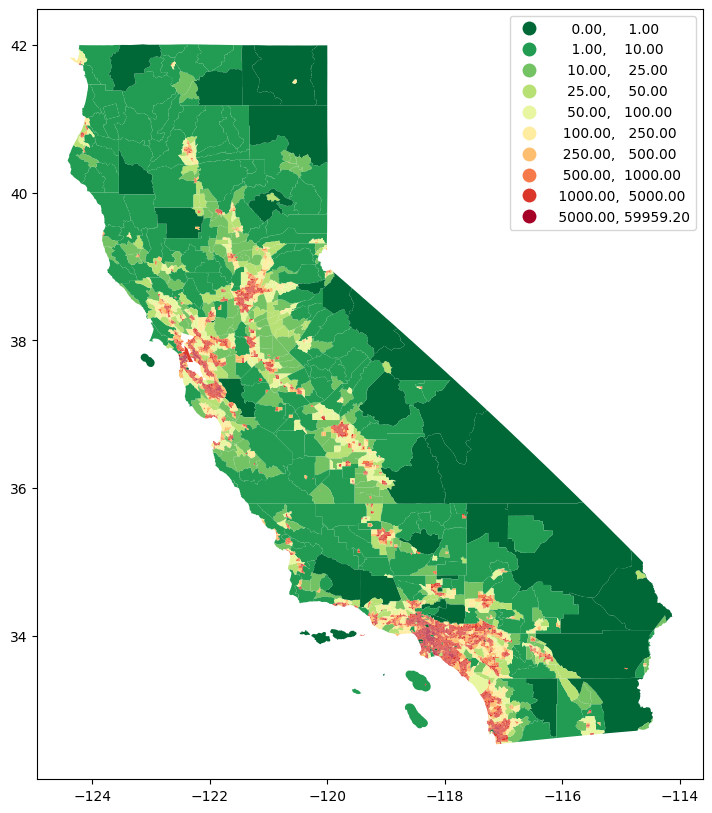

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=dict(bins=[1,10,25,50,100, 250, 500, 1000, 5000]),
         legend=True)

plt.show()

我们对地图进行最后的润色，并将结果保存为 PNG 文件。请记住，在显示图表之前调用 `plt.savefig()`，因为图表在显示后会被清空。

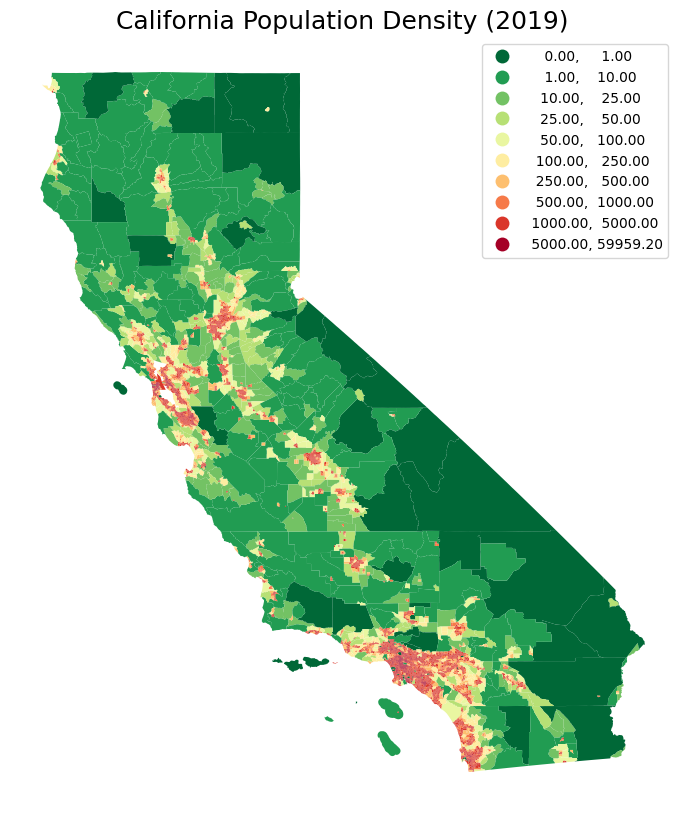

In [20]:
# 定义保存输出图片的路径，将图片保存为 'california_pop.png' 到指定文件夹
output_path = os.path.join(output_folder, 'california_pop.png')

# 创建一个包含 1 行 1 列子图的图形对象和轴对象
fig, ax = plt.subplots(1, 1)

# 设置图形的大小为 10x10 英寸
fig.set_size_inches(10, 10)

# 在指定的轴（ax）上绘制 GeoDataFrame (gdf)，根据 'density' 列着色
# 使用 'RdYlGn_r' 的颜色映射（红-黄-绿，反转）
# scheme 设置为 'User_Defined'，允许自定义分类
# 使用 classification_kwds 参数设置自定义的区间分类，bins 指定每个分类区间
# legend=True 表示在图形中添加图例
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=dict(bins=[1, 10, 25, 50, 100, 250, 500, 1000, 5000]),
         legend=True)

# 隐藏轴线
ax.set_axis_off()

# 设置图形的标题，并设置字体大小为 18
ax.set_title('California Population Density (2019)', size=18)

# 将图形保存为指定路径，设置分辨率为 300 dpi
plt.savefig(output_path, dpi=300)

# 显示绘制的图形
plt.show()


## 练习

绘制人口普查区的 GeoDataFrame `tracts`，只显示轮廓，不填充颜色。

> 提示：将 `facecolor` 选项设置为 `'none'` 以不填充颜色。有关更多详细信息，请查看 `plot()` 方法的 [*style_kwds* 参数](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)。

(1) Mapping and plotting tools — GeoPandas 1.0.1+0.g747d66e.dirty documentation. https://geopandas.org/en/stable/docs/user_guide/mapping.html.
(2) geopandas.GeoDataFrame.plot — GeoPandas 1.0.1+0.g747d66e.dirty .... https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html.
(3) geopandas.GeoDataFrame.plot — GeoPandas 0.10.2+79 .... https://www.osgeo.cn/geopandas/docs/reference/api/geopandas.GeoDataFrame.plot.html.

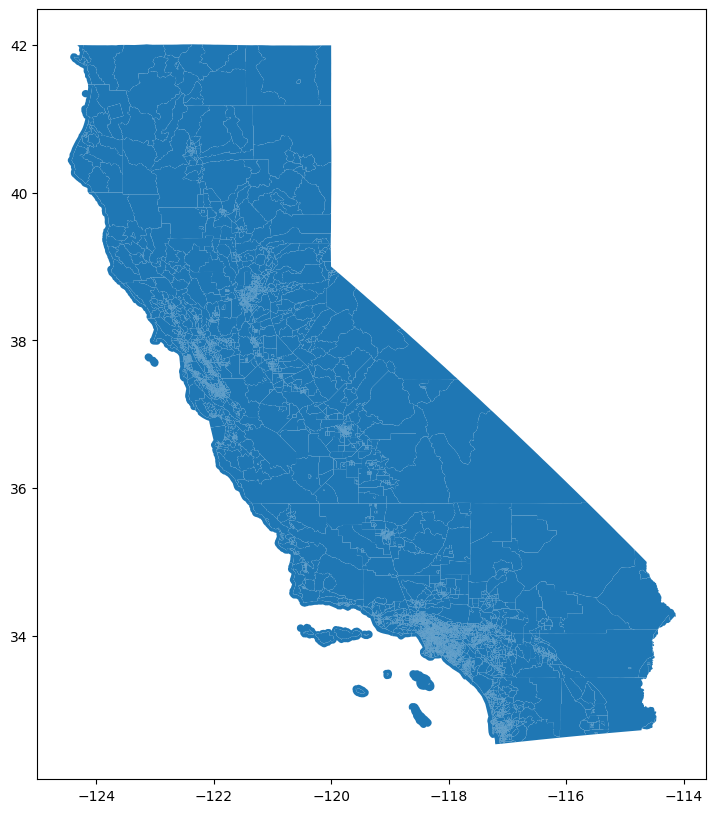

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
tracts.plot(ax=ax)
plt.show()

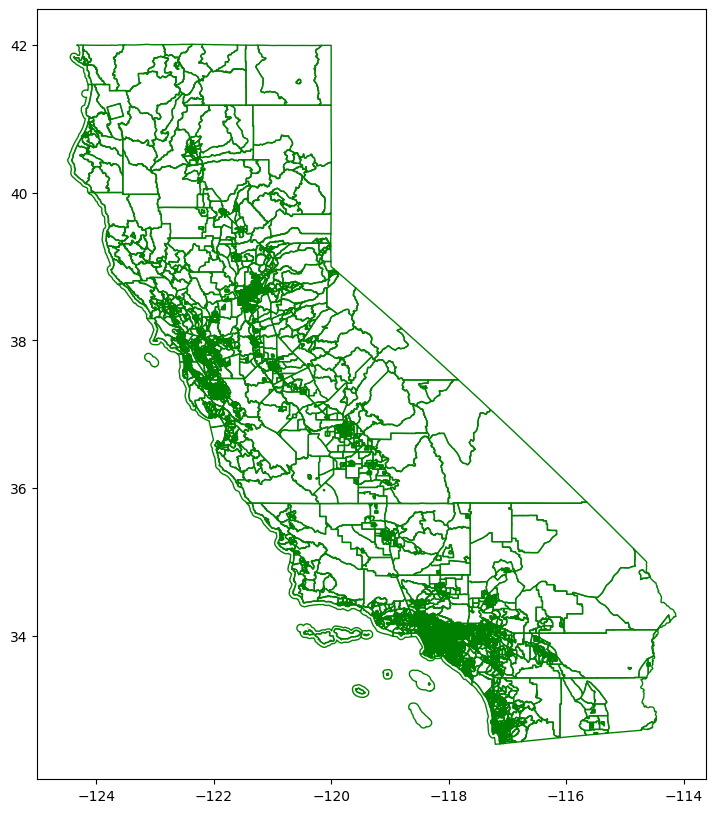

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

# 仅显示轮廓，不填充颜色
gdf.plot(ax=ax, edgecolor='green', facecolor='none')

# 显示图像
plt.show()


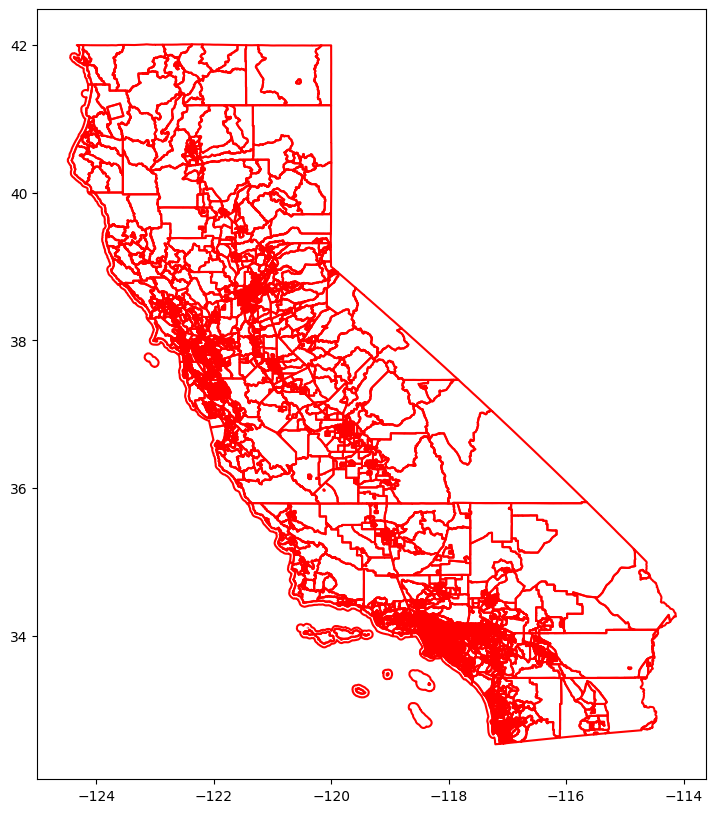

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

# 仅绘制轮廓，不填充颜色
gdf.boundary.plot(ax=ax, edgecolor='red')

# 显示图像
plt.show()



### GeoPandas 绘图总结

GeoPandas 结合了 Pandas 的数据操作能力和地理空间数据处理功能，使得我们能够方便地对地理数据进行可视化。它使用 Matplotlib 作为底层绘图库，并提供了简单易用的绘图接口。

#### 1. **基本绘图方法**
   - 使用 `gdf.plot()` 方法可以对 `GeoDataFrame` 进行简单的可视化。该方法可以自动识别几何数据并进行绘制。

   ```python
   gdf.plot()
   ```

#### 2. **自定义颜色和样式**
   - 通过 `facecolor` 设置填充颜色，`edgecolor` 设置边界颜色。
   
   ```python
   gdf.plot(facecolor='lightblue', edgecolor='black')
   ```

#### 3. **不填充颜色，只绘制轮廓**
   - 设置 `facecolor='none'` 以确保只绘制区域的轮廓而不填充颜色。
   
   ```python
   gdf.plot(facecolor='none', edgecolor='black')
   ```

#### 4. **列（属性）映射到颜色**
   - 使用 `column` 参数将 `GeoDataFrame` 中某列的值映射到颜色，通过 `cmap` 参数指定配色方案。
   
   ```python
   gdf.plot(column='population_density', cmap='OrRd', legend=True)
   ```

#### 5. **分类显示**
   - `scheme` 参数允许将数据按特定分类方式绘制（如自然断点、分位数等），需要 `mapclassify` 库的支持。
   
   ```python
   gdf.plot(column='density', cmap='RdYlGn', scheme='quantiles', legend=True)
   ```

#### 6. **显示几何对象的边界**
   - 使用 `gdf.boundary.plot()` 绘制几何对象的边界而不填充。
   
   ```python
   gdf.boundary.plot()
   ```

#### 7. **与 Matplotlib 的结合**
   - 可以通过传递 `ax` 参数，将 GeoPandas 绘图与 Matplotlib 图形结合，自定义图形大小、坐标轴、标题等。
   
   ```python
   fig, ax = plt.subplots(figsize=(10, 10))
   gdf.plot(ax=ax, edgecolor='blue')
   ax.set_title('Geopandas Plot')
   plt.show()
   ```

### GeoPandas 绘图的优势
- **简洁**：使用 `gdf.plot()` 即可快速绘制地理数据。
- **灵活性**：可以使用 Matplotlib 自定义图形，同时提供 `column` 参数来映射属性值到颜色。
- **空间分析功能强大**：GeoPandas 支持复杂的几何操作和空间分析，如缓冲区、交集等，绘图功能与其紧密结合。

`gdf.plot()` 是 GeoPandas 中用于绘制地理空间数据的核心函数，它基于 Matplotlib 库，提供了一种简洁方便的方式来可视化 `GeoDataFrame` 中的几何对象（如点、线、面）。以下是对 `gdf.plot()` 函数的详细介绍，包括其主要参数和使用方式。

### 基本语法
```python
gdf.plot(column=None, cmap=None, color=None, ax=None, figsize=None, legend=False, scheme=None, k=5, edgecolor=None, facecolor=None, linewidth=1, alpha=None, categorical=False, legend_kwds=None, classification_kwds=None, missing_kwds=None, **style_kwds)
```

### 主要参数介绍

#### 1. **`column`**
   - 说明：指定用于着色的列名。如果不设置此参数，`gdf.plot()` 会使用统一的颜色来绘制所有几何对象。
   - 用法：
     ```python
     gdf.plot(column='population_density')
     ```
   - 如果该列包含数值数据，GeoPandas 会根据值的范围自动为几何对象着色；如果该列包含分类数据（例如字符串），它会为每个类别分配不同的颜色。

#### 2. **`cmap`**
   - 说明：设置颜色映射（colormap），用于将数值数据映射为颜色。`cmap` 通常与 `column` 参数结合使用。
   - 用法：
     ```python
     gdf.plot(column='population_density', cmap='OrRd')
     ```
   - 常用的 `cmap` 值有：`viridis`、`Blues`、`OrRd`、`RdYlGn` 等。

#### 3. **`color`**
   - 说明：设置所有几何对象的统一颜色，如果不需要使用 `column` 来按属性值区分颜色时使用此参数。
   - 用法：
     ```python
     gdf.plot(color='lightblue')
     ```

#### 4. **`ax`**
   - 说明：将绘图输出到指定的 Matplotlib `axes` 对象。这允许在同一图形中绘制多个图层，或自定义绘图布局。
   - 用法：
     ```python
     fig, ax = plt.subplots()
     gdf.plot(ax=ax)
     ```

#### 5. **`figsize`**
   - 说明：设置图形的尺寸（宽、高），与 Matplotlib 中 `figsize` 参数一致。
   - 用法：
     ```python
     gdf.plot(figsize=(10, 10))
     ```

#### 6. **`legend`**
   - 说明：是否显示图例。通常与 `column` 一起使用来显示不同值对应的颜色。如果 `column` 是数值型数据，GeoPandas 会自动创建颜色条。
   - 用法：
     ```python
     gdf.plot(column='population_density', cmap='OrRd', legend=True)
     ```

#### 7. **`scheme`**
   - 说明：数据分类方案，用于将数据按指定规则分组。需要 `mapclassify` 库支持。常用的分类方法包括：
     - `'quantiles'`（分位数）
     - `'equal_interval'`（等间隔）
     - `'natural_breaks'`（自然断点）
   - 用法：
     ```python
     gdf.plot(column='population_density', cmap='OrRd', scheme='quantiles', k=5)
     ```
   - 参数 `k` 用于设置分类的数量。

#### 8. **`edgecolor` 和 `facecolor`**
   - 说明：`edgecolor` 设置几何对象的边界颜色，`facecolor` 设置填充颜色。你可以将 `facecolor='none'` 以不填充几何体。
   - 用法：
     ```python
     gdf.plot(edgecolor='black', facecolor='none')
     ```

#### 9. **`linewidth`**
   - 说明：设置边界线的宽度，特别适用于 `Polygon` 和 `LineString` 几何体。
   - 用法：
     ```python
     gdf.plot(linewidth=2, edgecolor='black')
     ```

#### 10. **`alpha`**
   - 说明：设置透明度。`alpha=0` 是完全透明，`alpha=1` 是不透明。
   - 用法：
     ```python
     gdf.plot(alpha=0.5)
     ```

#### 11. **`categorical`**
   - 说明：当数据是分类数据（如字符串或类别）时，将此参数设置为 `True`，以确保为每个类别分配不同的颜色。
   - 用法：
     ```python
     gdf.plot(column='land_use', categorical=True)
     ```

#### 12. **`legend_kwds`**
   - 说明：用于自定义图例的外观和位置，包括 `location`、`title`、`label` 等。
   - 用法：
     ```python
     gdf.plot(column='population_density', cmap='OrRd', legend=True, legend_kwds={'label': 'Population Density', 'orientation': 'horizontal'})
     ```

#### 13. **`classification_kwds`**
   - 说明：当使用 `scheme` 参数时，可以通过 `classification_kwds` 传递额外的参数来控制分类方式。例如，设置分类区间（`bins`）或调整 `quantiles` 的计算方式。
   - 用法：
     ```python
     gdf.plot(column='population_density', cmap='OrRd', scheme='user_defined', classification_kwds={'bins': [0, 100, 500, 1000, 5000]})
     ```

#### 14. **`missing_kwds`**
   - 说明：指定如何处理缺失值，包括颜色和标签设置。
   - 用法：
     ```python
     gdf.plot(column='population_density', missing_kwds={'color': 'lightgrey', 'label': 'No Data'})
     ```

### 常见绘图示例

1. **简单绘制几何对象**
   ```python
   gdf.plot()
   ```

2. **按列着色并显示图例**
   ```python
   gdf.plot(column='population_density', cmap='OrRd', legend=True)
   ```

3. **仅绘制边界线**
   ```python
   gdf.plot(edgecolor='black', facecolor='none')
   ```

4. **分组显示数据，按分位数分类**
   ```python
   gdf.plot(column='population_density', cmap='RdYlGn', scheme='quantiles', legend=True)
   ```

5. **自定义图例和分类区间**
   ```python
   gdf.plot(column='density', cmap='OrRd', scheme='user_defined', classification_kwds={'bins': [0, 100, 500, 1000, 5000]}, legend=True)
   ```

### 总结
`gdf.plot()` 是 GeoPandas 中功能强大且灵活的绘图工具。它可以根据地理数据的几何形状和属性值生成多种类型的可视化。结合 `Matplotlib` 的自定义功能，用户可以轻松生成复杂的地理空间数据可视化。